In [1]:
import pyspark # 
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression as LogisticRegressionPySpark
import pyspark.sql.functions as F 

import os 
import seaborn as sns 
import sklearn # 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score

import matplotlib # 
import matplotlib.pyplot as plt

import mlflow
import mlflow.spark

os.environ["SPARK_LOCAL_IP"] = '127.0.0.1'
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext._conf.getAll()

import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


c:\Users\user\miniconda3\envs\cc_env\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


In [2]:
print("pyspark: {}".format(pyspark.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("sklearn: {}".format(sklearn.__version__))
print("mlflow: {}".format(mlflow.__version__))




pyspark: 3.0.0
matplotlib: 3.2.1
seaborn: 0.10.1
sklearn: 0.22.1
mlflow: 1.23.1


PySpark: you must define a Spark context and a create a `Spark Session`.

It means that you are creating a point of connection to the `Spark engine`, enabling the engine to run all of the code related to Spark functionality. 


#### Load data set
* PySpark has its own functionality for creating data frames. `No need to use Pandas`

In [3]:
data_path = "D:\per\Codes\cloud_deployment\mlops\data\creditcard.csv\creditcard.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)
labelColumn = "Class"
columns = df.columns
numericCols = columns
numericCols.remove("Time")
numericCols.remove(labelColumn)
print(numericCols)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [4]:
labelColumn

'Class'

In [5]:
df.show(2)

+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
|Time|              V1|                 V2|              V3|               V4|                V5|                 V6|                 V7|                V8|                V9|               V10|               V11|               V12|               V13|               V14|              V15|               V16|               V17|               V18|               V19|                V20|               V21|               V22|               V23|       

In [6]:
# convert PySpark data frames into pandas data frames 
df.toPandas().head()

c:\Users\user\miniconda3\envs\cc_env\lib\site-packages\pyspark\sql\pandas\conversion.py:88: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.15.1 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


* `PySpark's built-in` functionality to convert the spark data frame into pandas data frame for easier viewing
* If a data frame has a lot of columns it'd be great to convert the `Spark data frame` into `Pandas` for viewing

To train the model, you would need to pass in a vector called `features`

In [7]:
stages = []
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

dfFeatures = df.select(F.col(labelColumn).alias('label'), *numericCols)

* defines the inputs to the assembler so that it knows what columns to transform into the features vector
* also constructing the `VectorAssembler` that will be used later to create a feature vector from the input data. 

In [8]:
dfFeatures

DataFrame[label: int, V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, Amount: double]

In [9]:
#add cell to the above and create the normal and anomaly data splits 
normal = dfFeatures.filter("Class == 0").sample(withReplacement=False, fraction=0.5, seed=2020)
anomaly = dfFeatures.filter("Class == 1")

normal_train, normal_test = normal.randomSplit([0.8, 0.2], seed=2020)
anomaly_train, anomaly_test = anomaly.randomSplit([0.8, 0.2], seed=2020)

* Normal and anomaly data split similar to scikit-learn's, and split it into training and testing subsets

In [10]:
dfFeatures.toPandas().head()

c:\Users\user\miniconda3\envs\cc_env\lib\site-packages\pyspark\sql\pandas\conversion.py:88: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.15.1 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


,label,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


Now `combine the respective normal & anomaly splits` to form your training and testing sets. 

In [11]:
# No validation set, looking at an 80-20 split btn the training and testing data
# creating the training and testing sets with PySpark's functionality
train_set = normal_train.union(anomaly_train)
test_set = normal_test.union(anomaly_test)

Rest of the pipeline with the feature vector

In [12]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(dfFeatures)
train_set = pipelineModel.transform(train_set)
test_set = pipelineModel.transform(test_set)

selectedCols = ['label', 'features'] + numericCols
train_set = train_set.select(selectedCols)
test_set = test_set.select(selectedCols)

print("Training Dataset Count: ", train_set.count())
print("Test Dataset Count: ", test_set.count())


Training Dataset Count:  113995
Test Dataset Count:  28569


* created a `feature vector` from the data frame using the pipeline. Now, train `logistic regression model` on the feature vector

### Model Training

In [13]:
def train(spark_model, train_set):

    trained_model = spark_model.fit(train_set)

    trainingSummary = trained_model.summary
    pyspark_auc_score = trainingSummary.areaUnderROC

    mlflow.log_metric("train_acc", trainingSummary.accuracy)
    mlflow.log_metric("train_AUC", pyspark_auc_score)

    print("Training Accuracy: ", trainingSummary.accuracy)
    print("Training AUC: ", pyspark_auc_score)

    return trained_model


* Defining the PySpark logistic regression model and log the training accuracy and the AUC score metrics  

### Model Evaluation

In [14]:
# predictions = lrModel.transform(test)

# y_true = predictions.select(['label']).collect()
# y_pred = predictions.select(['prediction']).collect()

# evaluations = lrModel.evaluate(test)
# accuracy = evaluations.accuracy

def evaluate(spark_model, test_set):
    evaluation_summary = spark_model.evaluate(test_set)

    eval_acc = evaluation_summary.accuracy
    eval_AUC = evaluation_summary.areaUnderROC

    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("eval_AUC", eval_AUC)

    print("Evaluation Accuracy: ", eval_acc)
    print("Evaluation AUC: ", eval_AUC)

* Evaluates the trained PySpark logistic regression model model and log the evaluation accuracy and AUC Score metrics.
* `AUC Score` is calculated using `scikit-learn's` scoring algorithm, while the `PySpark AUC Score metric` comes from the training summary of the `PySpark model`

### MLFlow Run - Training, UI, and Loading an MLFlow Model

In [16]:
# test = train(lr, train_set)

In [50]:
test

LogisticRegressionModel: uid=LogisticRegression_a42cf0f54583, numClasses=2, numFeatures=29

In [17]:
# start MLFlow run and build a model
lr = LogisticRegressionPySpark(featuresCol='features', labelCol='label', maxIter=10)

mlflow.set_experiment("PySpark_CreditCard")  # create an experiment

with mlflow.start_run():
    trainedLR = train(lr, train_set)

    evaluate(trainedLR, test_set)

    mlflow.spark.log_model(trainedLR, "creditcard_model_pyspark")

mlflow.end_run()



Training Accuracy:  0.9987981929031975
Training AUC:  0.9805692880720026
Evaluation Accuracy:  0.9991249256186776
Evaluation AUC:  0.9677957524292414


Py4JJavaError: An error occurred while calling o329.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:100)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1090)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1088)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1061)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1008)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1007)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:964)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:962)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1552)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1552)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1538)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1538)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1(Pipeline.scala:250)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1$adapted(Pipeline.scala:247)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.saveImpl(Pipeline.scala:247)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.saveImpl(Pipeline.scala:346)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:176)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:171)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:344)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 65.0 failed 1 times, most recent failure: Lost task 0.0 in stage 65.0 (TID 314, kubernetes.docker.internal, executor driver): java.io.IOException: (null) entry in command string: null chmod 0644 D:\tmp\mlflow\28418ffb-4a7b-4470-90e2-e6de31658dc6\metadata\_temporary\0\_temporary\attempt_20230719230700_0211_m_000000_0\part-00000
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:773)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:869)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:852)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:733)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:225)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:209)
	at org.apache.hadoop.fs.RawLocalFileSystem.createOutputStreamWithMode(RawLocalFileSystem.java:307)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:296)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:328)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.<init>(ChecksumFileSystem.java:398)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:461)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:804)
	at org.apache.hadoop.mapred.TextOutputFormat.getRecordWriter(TextOutputFormat.java:123)
	at org.apache.spark.internal.io.HadoopMapRedWriteConfigUtil.initWriter(SparkHadoopWriter.scala:230)
	at org.apache.spark.internal.io.SparkHadoopWriter$.executeTask(SparkHadoopWriter.scala:120)
	at org.apache.spark.internal.io.SparkHadoopWriter$.$anonfun$write$1(SparkHadoopWriter.scala:83)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2146)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:78)
	... 67 more
Caused by: java.io.IOException: (null) entry in command string: null chmod 0644 D:\tmp\mlflow\28418ffb-4a7b-4470-90e2-e6de31658dc6\metadata\_temporary\0\_temporary\attempt_20230719230700_0211_m_000000_0\part-00000
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:773)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:869)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:852)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:733)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:225)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:209)
	at org.apache.hadoop.fs.RawLocalFileSystem.createOutputStreamWithMode(RawLocalFileSystem.java:307)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:296)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:328)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.<init>(ChecksumFileSystem.java:398)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:461)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:804)
	at org.apache.hadoop.mapred.TextOutputFormat.getRecordWriter(TextOutputFormat.java:123)
	at org.apache.spark.internal.io.HadoopMapRedWriteConfigUtil.initWriter(SparkHadoopWriter.scala:230)
	at org.apache.spark.internal.io.SparkHadoopWriter$.executeTask(SparkHadoopWriter.scala:120)
	at org.apache.spark.internal.io.SparkHadoopWriter$.$anonfun$write$1(SparkHadoopWriter.scala:83)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


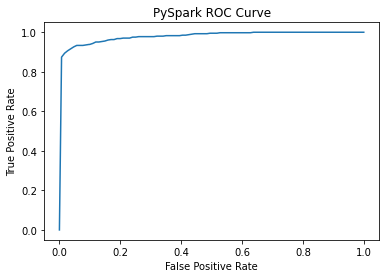

In [20]:
#examine the scores on a graph
pyspark_roc = trainingSummary.roc.toPandas()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PySpark ROC Curve')
plt.plot(pyspark_roc['FPR'], pyspark_roc['TPR'])

> ROC Curve for the *PySpark logistic regression model*
> A perfect ROC Curve would have the *true positive rate* starting at *1.0*, where it continues right to a *false positive rate* value of 1.0. 
* This curve is quite close to that, hence why its area (AUC) is said to be around *0.97997 by PySpark*, keeping in mind a <a>perfect AUC Score</a> is *1.00*

Text(0.5, 15.0, 'predicted')

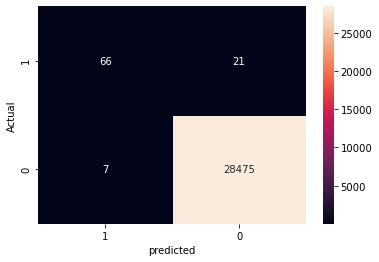

In [21]:
# the confusion matrix to check the model performance
conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('predicted')

* the accuracy of the correctly labeled points for the normal data is very high and is decent for the anomalous data
* anomalies -> the model has a 75.86% accuracy (66/(66+21)) in predicting anomalies
* normal points -> good accuracy of 99.98% (28475/(28475+7))
* haven't tuned the hyperparameter to attain maximum performance. 